# Radon-Transform (CPU)

## Setup

In [2]:
from math import sin, cos, ceil
import time
import typing
import torch
import torchvision
import matplotlib.pyplot as plt
if torch.cuda.is_available():
    import torch_radon
import radon

In [3]:
def shepp_logan_phantom(n):
    phantom = torch.zeros((n,n))
    centers = torch.tensor([[0, 0], [0, -0.0184], [0.11, 0], [-0.11, 0], [0, 0.175], [0, 0.05], [0, -0.05], [-0.04, -0.3025], [0, -0.3025], [0.03, -0.3025]])
    axes = torch.tensor([[0.69, 0.92], [0.6624, 0.874], [0.11, 0.31], [0.16, 0.41], [0.21, 0.25], [0.046, 0.046], [0.046, 0.046], [0.046, 0.023], [0.023, 0.023], [0.023, 0.046]])
    theta = torch.tensor([0, 0, -0.31415926535, 0.31415926535, 0, 0, 0, 0, 0, 0])
    intensity = torch.tensor([2, -1.0, -0.2, -0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    x,y = torch.meshgrid(torch.linspace(-0.5, 0.5, n), -torch.linspace(-0.5, 0.5, n), indexing="ij")
    with torch.no_grad():
        for i in range(10):
            phantom[
                torch.square((x-centers[i,0])*cos(theta[i])+(y-centers[i,1])*sin(theta[i]))/((axes[i,0]/2.0)**2)+
                torch.square((x-centers[i,0])*sin(theta[i])-(y-centers[i,1])*cos(theta[i]))/((axes[i,1]/2.0)**2)
                <= 1.0] += intensity[i]
    return phantom.T/2.0

## Matrix

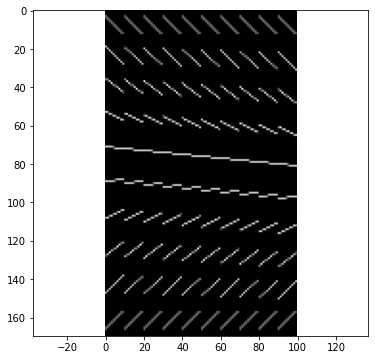

In [4]:
matrix = radon.radon_matrix(torch.zeros((10,10)), torch.linspace(0.0, torch.pi, 10)).reshape(170, 100)
plt.figure(figsize=(6,6))
plt.imshow(matrix, cmap="gray")
plt.axis("equal")
plt.show()

## Examples

### Python functions

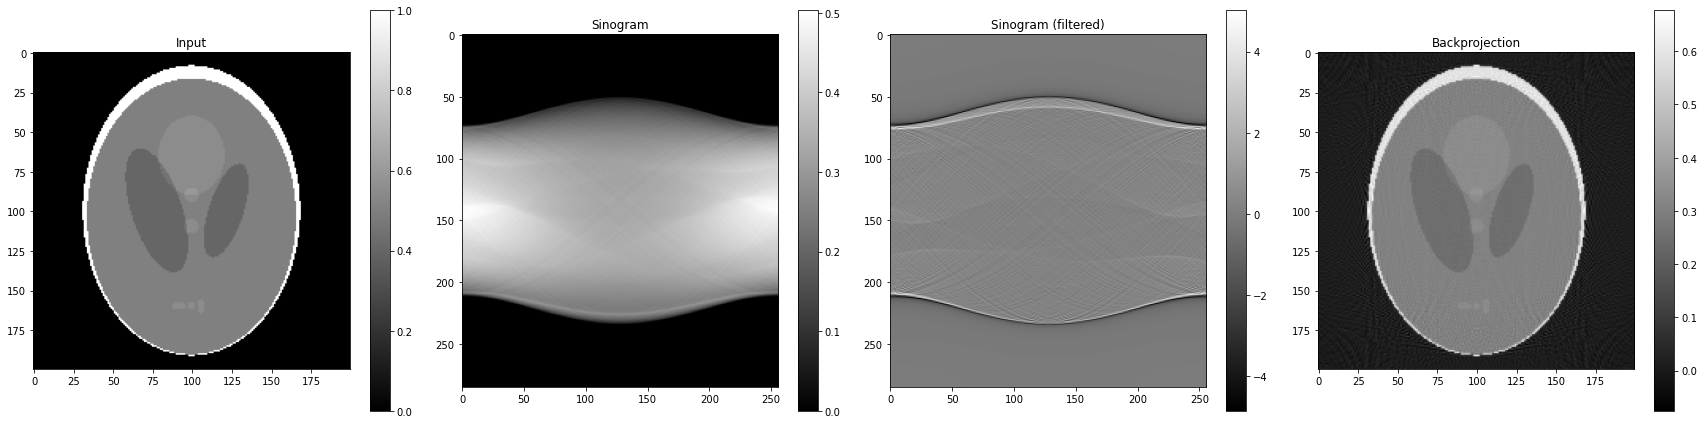

In [5]:
img0 = shepp_logan_phantom(200).contiguous().unsqueeze(0).unsqueeze(0).requires_grad_(True)
plt.subplots(1, 4, figsize=(24,6))
plt.subplot(1, 4, 1)
plt.title("Input")
plt.imshow(img0[0,0].detach().to("cpu"), cmap="gray")
plt.colorbar()
sino0 = radon.radon_forward(img0)
plt.subplot(1, 4, 2)
plt.title("Sinogram")
plt.imshow(sino0[0,0,:,:].flip(0).flip(1).detach().to("cpu").mT, cmap="gray")
plt.colorbar()
fsino0 = radon.radon_filter(sino0, radon.ram_lak_filter, None)
plt.subplot(1, 4, 3)
plt.title("Sinogram (filtered)")
plt.imshow(fsino0[0,0].detach().to("cpu").mT, cmap="gray")
plt.colorbar()
recon0 = radon.radon_backward(fsino0, img0.shape[3])
plt.subplot(1, 4, 4)
plt.title("Backprojection")
plt.imshow(recon0[0,0].detach().to("cpu"), cmap="gray") 
plt.colorbar()
plt.tight_layout()
plt.show()

### Torch-Autograd-Function

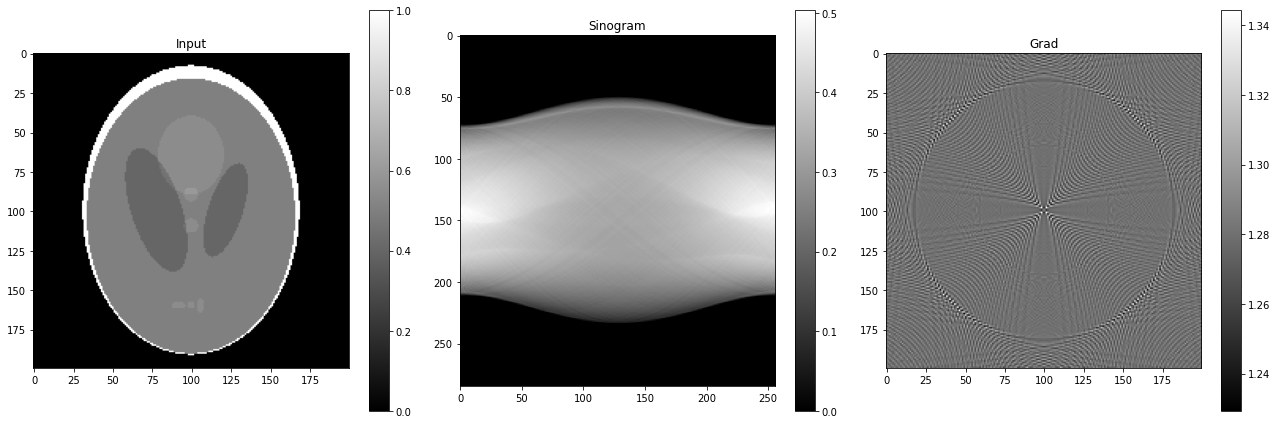

In [5]:
img1 = shepp_logan_phantom(200).contiguous().unsqueeze(0).unsqueeze(0).requires_grad_(True)
plt.subplots(1, 3, figsize=(18,6))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(img1[0,0].detach(), cmap="gray")
plt.colorbar()
sino1 = radon.RadonForwardFunc.apply(img1)
plt.subplot(1, 3, 2)
plt.title("Sinogram")
plt.imshow(sino1[0,0].detach().mT, cmap="gray")
plt.colorbar()
sino1.sum().backward()
grad = typing.cast(torch.Tensor, img1.grad)
plt.subplot(1, 3, 3)
plt.title("Grad")
plt.imshow(grad[0,0].detach(), cmap="gray")
plt.colorbar()
plt.tight_layout()
plt.show()

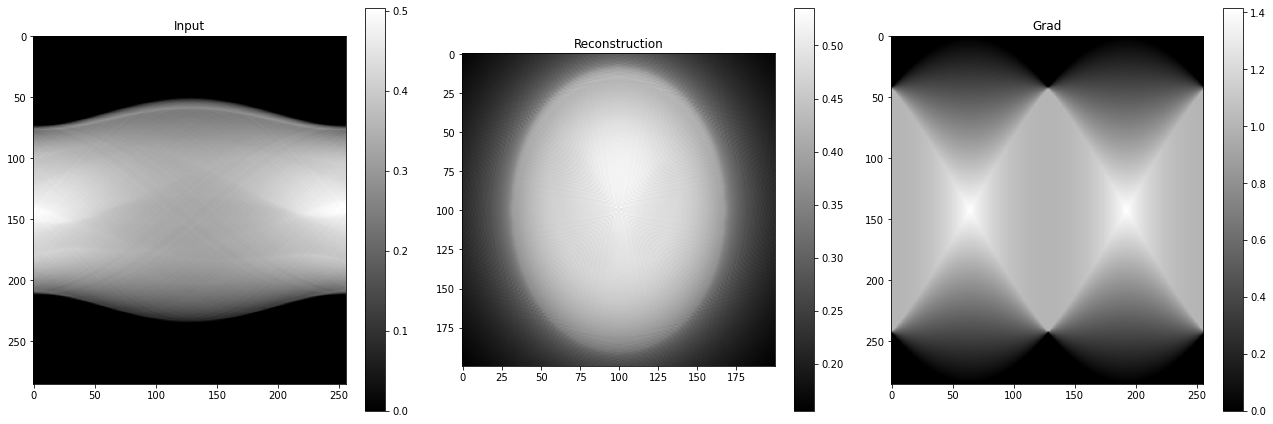

In [6]:
sino = radon.radon_forward(shepp_logan_phantom(200).contiguous().unsqueeze(0).unsqueeze(0)).requires_grad_(True)
plt.subplots(1, 3, figsize=(18,6))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(sino[0,0].detach().mT, cmap="gray")
plt.colorbar()
img = radon.RadonBackwardFunc.apply(sino, 200)
plt.subplot(1, 3, 2)
plt.title("Reconstruction")
plt.imshow(img[0,0].detach(), cmap="gray")
plt.colorbar()
img.sum().backward()
grad = typing.cast(torch.Tensor, sino.grad)
plt.subplot(1, 3, 3)
plt.title("Grad")
plt.imshow(grad[0,0].detach().mT, cmap="gray")
plt.colorbar()
plt.tight_layout()
plt.show()

### Torch-Module

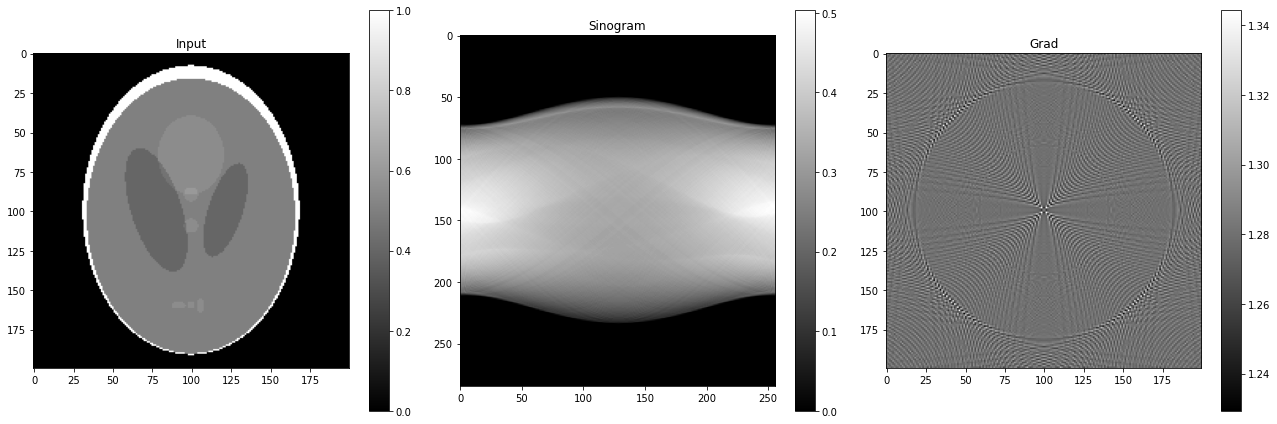

In [7]:
radon_trans = radon.RadonForward()
img2 = shepp_logan_phantom(200).contiguous().unsqueeze(0).unsqueeze(0).requires_grad_(True)
plt.subplots(1, 3, figsize=(18,6))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(img2[0,0].detach(), cmap="gray")
plt.colorbar()
sino2 = radon_trans(img2)
plt.subplot(1, 3, 2)
plt.title("Sinogram")
plt.imshow(sino2[0,0].detach().mT, cmap="gray")
plt.colorbar()
sino2.sum().backward()
recon2 = typing.cast(torch.Tensor, img2.grad)
plt.subplot(1, 3, 3)
plt.title("Grad")
plt.imshow(recon2[0,0].detach(), cmap="gray")
plt.colorbar()
plt.tight_layout()
plt.show()

## Comparison

### Torch-Radon

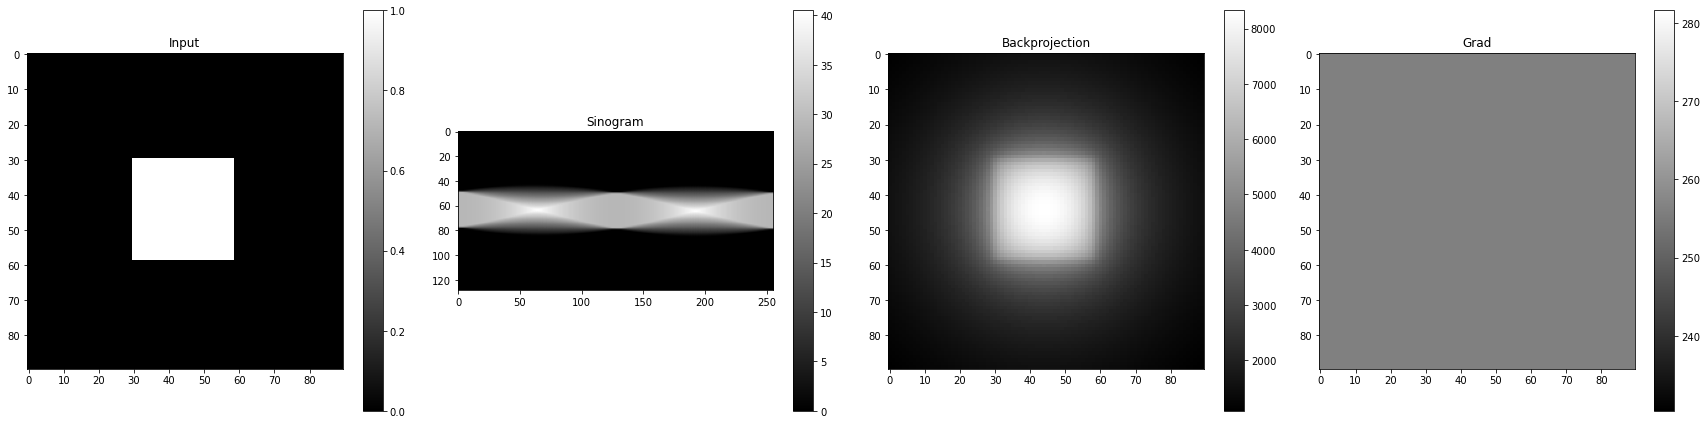

In [8]:
if torch.cuda.is_available():
    torchradon = torch_radon.Radon(90, torch.linspace(0.0, 3.14159265359, 257)[:-1], 129, 1)
    img3 = torch.zeros((1,1,90,90), device="cuda")
    img3[0, 0, 30:59,30:59] = 1.0
    img3.requires_grad = True
    plt.subplots(1, 4, figsize=(24,6))
    plt.subplot(1, 4, 1)
    plt.title("Input")
    plt.imshow(img3.detach().to("cpu")[0,0], cmap="gray")
    plt.colorbar()
    sino3 = torchradon.forward(img3)
    plt.subplot(1, 4, 2)
    plt.title("Sinogram")
    plt.imshow(sino3.detach().to("cpu")[0,0].mT, cmap="gray")
    plt.colorbar()
    recon3 = torchradon.backward(sino3)
    plt.subplot(1, 4, 3)
    plt.title("Backprojection")
    plt.imshow(recon3.detach().to("cpu")[0,0], cmap="gray")
    plt.colorbar()
    sino3.sum().backward()
    plt.subplot(1, 4, 4)
    plt.title("Grad")
    plt.imshow(typing.cast(torch.Tensor, img3.grad).detach().to("cpu")[0,0], cmap="gray")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

### Ours

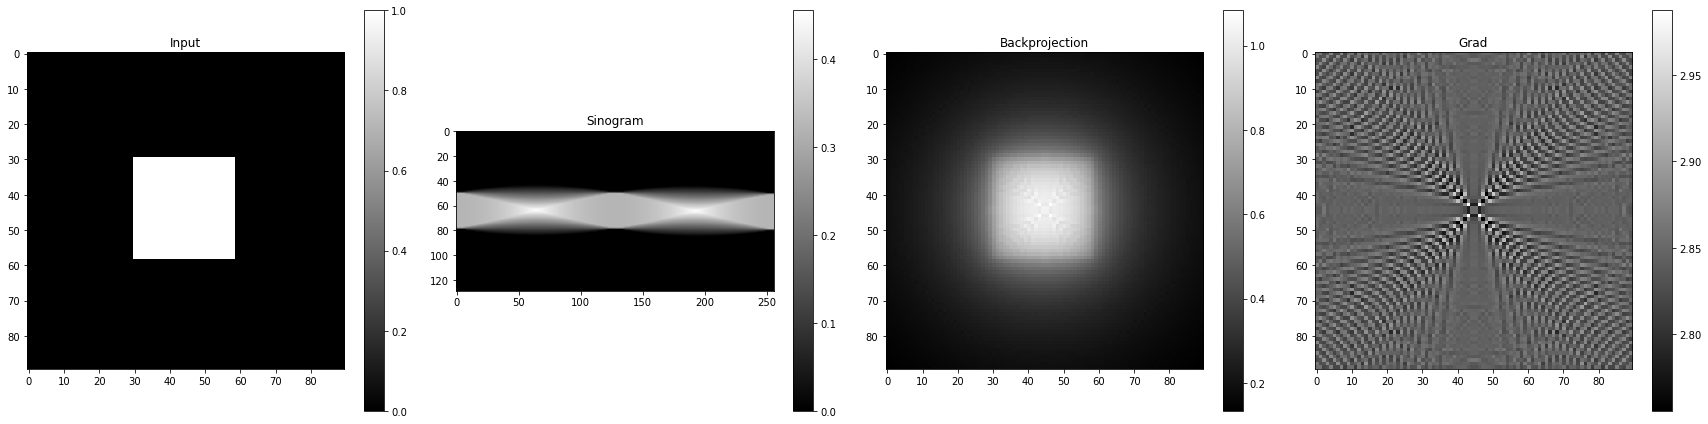

In [9]:
img4 = torch.zeros((1,1,90,90))
img4[0, 0, 30:59,30:59] = 1.0
plt.subplots(1, 4, figsize=(24,6))
plt.subplot(1, 4, 1)
plt.title("Input")
plt.imshow(img4[0,0], cmap="gray")
plt.colorbar()
sino4 = radon.RadonForwardFunc.apply(img4)
plt.subplot(1, 4, 2)
plt.title("Sinogram")
plt.imshow(sino4[0,0].mT, cmap="gray")
plt.colorbar()
recon4 = radon.radon_backward(sino4, img4.shape[3])
plt.subplot(1, 4, 3)
plt.title("Backprojection")
plt.imshow(recon4[0,0], cmap="gray")
plt.colorbar()
img4.requires_grad = True
radon.RadonForwardFunc.apply(img4).sum().backward()
plt.subplot(1, 4, 4)
plt.title("Grad")
plt.imshow(typing.cast(torch.Tensor, img4.grad).detach()[0,0], cmap="gray")
plt.colorbar()
plt.tight_layout()
plt.show()

### Difference

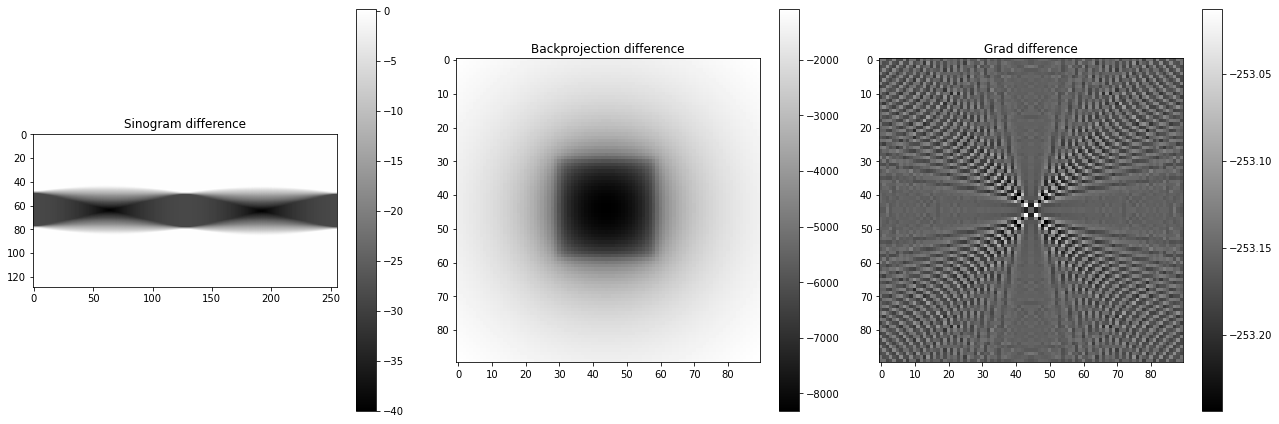

In [10]:
plt.subplots(1, 3, figsize=(18,6))
plt.subplot(1, 3, 1)
plt.title("Sinogram difference")
plt.imshow((sino4[0,0]-sino3.detach().to("cpu")[0,0]).mT, cmap="gray")
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title("Backprojection difference")
plt.imshow((recon4[0,0]-recon3.detach().to("cpu")[0,0]), cmap="gray")
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("Grad difference")
plt.imshow((typing.cast(torch.Tensor, img4.grad).detach()[0,0]-typing.cast(torch.Tensor, img3.grad).detach().to("cpu")[0,0]), cmap="gray")
plt.colorbar()
plt.tight_layout()
plt.show()

## Runtime

In [11]:
img = shepp_logan_phantom(200).contiguous().unsqueeze(0).unsqueeze(0).repeat(32,1,1,1)
sino = radon.radon_forward(img)
sinof = radon.radon_filter(sino, radon.ram_lak_filter, None)
N = 10
acc_time_ns = 0
for i in range(N):
    start_time_ns = time.perf_counter_ns()
    radon.radon_forward(img)
    acc_time_ns += time.perf_counter_ns()-start_time_ns
print(f"Forward transform: {acc_time_ns/(N*32e9)} s (avg of {N} runs with batches of size 32)")
acc_time_ns = 0
for i in range(N):
    start_time_ns = time.perf_counter_ns()
    radon.radon_filter(sino, radon.ram_lak_filter, None)
    acc_time_ns += time.perf_counter_ns()-start_time_ns
print(f"Filtering: {acc_time_ns/(N*32e9)} s (avg of {N} runs with batches of size 32)")
acc_time_ns = 0
for i in range(N):
    start_time_ns = time.perf_counter_ns()
    radon.radon_backward(sinof, 200)
    acc_time_ns += time.perf_counter_ns()-start_time_ns
print(f"Backward transform: {acc_time_ns/(N*32e9)} s (avg of {N} runs with batches of size 32)")

Forward transform: 0.124780463371875 s (avg of 10 runs with batches of size 32)
Filtering: 6.1604896875e-05 s (avg of 10 runs with batches of size 32)
Backward transform: 0.10186257118125 s (avg of 10 runs with batches of size 32)
